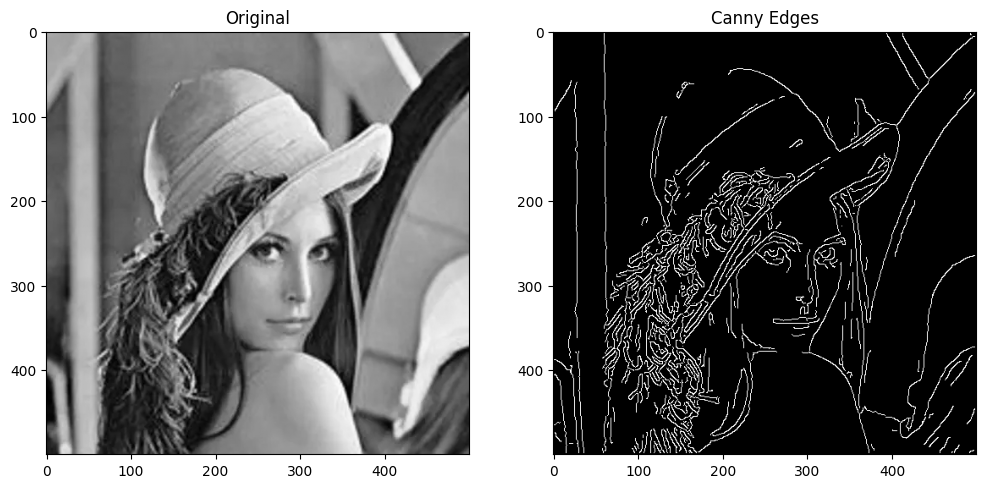

In [ ]:
import numpy as np
from PIL import Image
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

# 1. Load image and convert to grayscale
img = Image.open("input.jpg").convert("L")
img = np.array(img, dtype=np.float32)

# 2. Gaussian Blur (5x5 kernel)
def gaussian_kernel(size=5, sigma=1):
    ax = np.linspace(-(size-1)//2, (size-1)//2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2*sigma**2))
    return kernel / np.sum(kernel)

gauss = gaussian_kernel(5, 1)
smoothed = convolve(img, gauss)

# 3. Sobel Gradient (Gx, Gy)
Kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32)
Ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=np.float32)

Gx = convolve(smoothed, Kx)
Gy = convolve(smoothed, Ky)

magnitude = np.hypot(Gx, Gy)    # Edge strength
magnitude = magnitude / magnitude.max() * 255
theta = np.arctan2(Gy, Gx)      # Edge direction

# 4. Non-Maximum Suppression
def non_max_suppression(mag, theta):
    M, N = mag.shape
    Z = np.zeros((M,N), dtype=np.float32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            q = 255
            r = 255

            # angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = mag[i, j+1]
                r = mag[i, j-1]
            # angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = mag[i+1, j-1]
                r = mag[i-1, j+1]
            # angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = mag[i+1, j]
                r = mag[i-1, j]
            # angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = mag[i-1, j-1]
                r = mag[i+1, j+1]

            if (mag[i,j] >= q) and (mag[i,j] >= r):
                Z[i,j] = mag[i,j]
            else:
                Z[i,j] = 0
    return Z

nms = non_max_suppression(magnitude, theta)

# 5. Double Thresholding
def threshold(img, low, high):
    strong = 255
    weak = 50

    res = np.zeros_like(img, dtype=np.uint8)

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    return res, weak, strong

lowThreshold = 20
highThreshold = 40
thresh, weak, strong = threshold(nms, lowThreshold, highThreshold)

# 6. Edge Tracking by Hysteresis
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i,j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img

final = hysteresis(thresh, weak, strong)

# Show results
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(img, cmap="gray")
plt.subplot(1,2,2); plt.title("Canny Edges"); plt.imshow(final, cmap="gray")
plt.show()
